#### Import the libraries

In [42]:
# For data handling and EDA
import pandas as pd
# For Visualisation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
# For NLP and ML
import torch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
import nltk
import spacy

#### Load the dataset to Pandas

In [2]:
# Load the annotations metadata csv to get label info
annot = pd.read_csv("hate-speech-dataset-master/annotations_metadata.csv")
# Keep only file id and label
annot.drop(columns=['user_id','subforum_id','num_contexts'],inplace=True)
# Add new empty column to insert the message
annot['message']=''
# Loop through all lines
for i in range(len(annot['file_id'])):
    # Get current filename
    filename = annot['file_id'][i]
    # Open the file and read the contents
    with open('hate-speech-dataset-master/all_files/' +filename +'.txt') as f:
        contents= f.read()
    f.close()
    # Add contents to the message column
    annot['message'][i]=contents
# Drop file id
annot.drop(columns=['file_id'],inplace=True)

#### EDA and Pre-Processing

In [3]:
# DataFrame information
annot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10944 entries, 0 to 10943
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    10944 non-null  object
 1   message  10944 non-null  object
dtypes: object(2)
memory usage: 171.1+ KB


In [4]:
# Check the classes and their value counts
annot['label'].value_counts()

noHate      9507
hate        1196
relation     168
idk/skip      73
Name: label, dtype: int64

Based on the original paper, there are a total of 10944 sentences, 9507 of them are classified as no hate speech, 1196 are classified as hate speech, 168 are related to hate speech but depends on content and 73 are non English sentences, classified as idk/skip. For the purpose of this research, relation and idk/skip classes will be dropped completely in order to make the problem a binary classification.

In [5]:
# Keep sentences classified only as noHate and hate
cleanPosts = annot[(annot['label'] != 'relation') & (annot['label'] != 'idk/skip')]
# Reset index
cleanPosts=cleanPosts.reset_index(drop=True)

In [6]:
# First 5 data points
cleanPosts.head(5)

,label,message
0,noHate,"As of March 13th , 2014 , the booklet had been..."
1,noHate,In order to help increase the booklets downloa...
2,noHate,( Simply copy and paste the following text int...
3,hate,Click below for a FREE download of a colorfull...
4,noHate,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...


In [7]:
# Last 5 data points
cleanPosts.tail(5)

,label,message
10698,noHate,"Billy - `` That guy would n't leave me alone ,..."
10699,noHate,Wish we at least had a Marine Le Pen to vote f...
10700,noHate,Its like the choices are white genocide candid...
10701,hate,Why White people used to say that sex was a si...
10702,noHate,Now I get it !


In [8]:
# Update STOPWORDS
stop_words = STOPWORDS.update(["https", "S"])

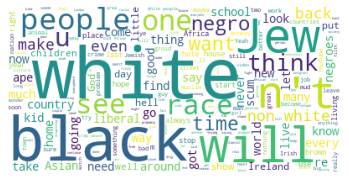

In [9]:
# WordCloud for posts classified as hate
wc_hate = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts['message'][cleanPosts['label']=='hate']))
# Generate plot
plt.imshow(wc_hate)
plt.axis("off")
plt.show()

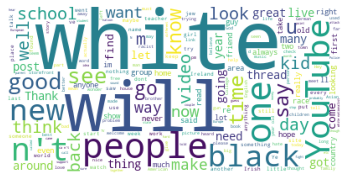

In [10]:
# WordCloud for posts classified as noHate
wc_noHate = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts['message'][cleanPosts['label']=='noHate']))
# Generate plot
plt.imshow(wc_noHate)
plt.axis("off")
plt.show()

#### Recreating Paper Results

#### Pre-Process text with SpaCy

Before I proceed with the Bag of Words model, I need to pre-process the text (remove punctuations, stop words, lemmatize) in order to reduce the vocabulary size. I will use SpaCy for text pre-processing.

In [11]:
# Get English words from NLTK
#nltk.download('words')
words = set(nltk.corpus.words.words())
# Instantiate SpaCy's English module
nlp = spacy.load('en_core_web_sm')
# Remove default stop words and lemmatize each sentence
cleanPosts['clean_message'] = cleanPosts.message.apply(
    lambda text: 
        " ".join(
            token.lemma_.lower() for token in nlp(text)
                if token.lemma_.lower() not in nlp.Defaults.stop_words and token.is_alpha and token.lemma_.lower() in words
        )
)
# Drop old sentences
cleanPosts.drop(columns='message', inplace=True)

In [12]:
# First 5 data points
cleanPosts.head(5)

,label,clean_message
0,noHate,march booklet time counting
1,noHate,order help increase booklet great account disp...
2,noHate,simply copy paste follow text video descriptio...
3,hate,click free colorfully illustrate page e book e...
4,noHate,click green banner link


In [13]:
# Last 5 data points
cleanPosts.tail(5)

,label,clean_message
10698,noHate,billy guy leave salute
10699,noHate,wish marine pen vote canada
10700,noHate,like choice white genocide candidate
10701,hate,white people use sex sin use mystery child bro...
10702,noHate,


In [14]:
# Check for empty strings and remove
cleanPosts[cleanPosts['clean_message'] == ''].count()

label            477
clean_message    477
dtype: int64

There are 477 empty entries after lemmatization and removing stop words, which I am going to remove.

In [15]:
# Drop rows where 'clean_message' is an empty string
# Get index
idx = cleanPosts[cleanPosts['clean_message'] == ''].index
# Drop rows based on index
cleanPosts.drop(index=idx, inplace=True)

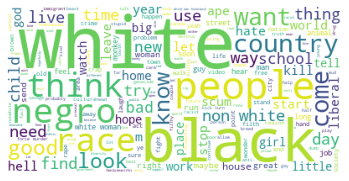

In [16]:
# WordCloud for cleaned posts classified as hate
wc_hate_clean = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts['clean_message'][cleanPosts['label']=='hate']))
# Generate plot
plt.imshow(wc_hate_clean)
plt.axis("off")
plt.show()

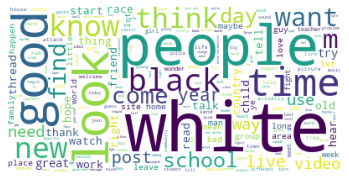

In [17]:
# WordCloud for cleaned posts classified as noHate
wc_noHate_clean = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts['clean_message'][cleanPosts['label']=='noHate']))
# Generate plot
plt.imshow(wc_noHate_clean)
plt.axis("off")
plt.show()

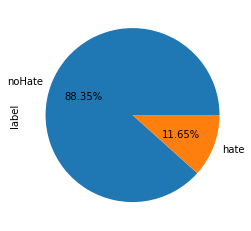

In [18]:
# Plot the class distribution
plot = cleanPosts.label.value_counts().plot(kind='pie',autopct='%1.2f%%')

#### Bag-of-Words Vectors

In [27]:
# Instantiate Count Vectorizer
vectorizer = CountVectorizer()
# Vectorize
X = vectorizer.fit_transform(cleanPosts.clean_message.to_list())
X_bow = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())

In [33]:
# Split dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_bow, cleanPosts.label, test_size=0.25, random_state=42, stratify=cleanPosts.label)

In [40]:
# Instatiate SVC
svm = LinearSVC()
# Fit training data
svm.fit(X_train, y_train)
# Get prediction on test data
pred = svm.predict(X_test)

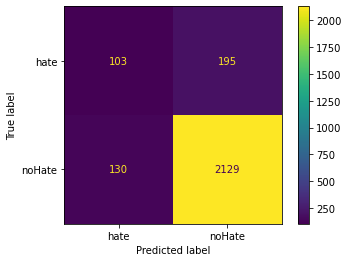

In [43]:
# Create confusion matrix
cm = confusion_matrix(y_test, pred, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()